In [1]:
import numpy as np
import os
import random
from copy import deepcopy
import torchvision, cv2
from skimage import filters, morphology, restoration, transform
import matplotlib as plt
import matplotlib as mpl
from pathlib import Path
from matplotlib import cm
from utils.plots import plot_confusion_matrix
import utils.dataset as ds
from utils.transforms import *
from utils.plots import *
from utils.experiment import Experiment
from utils.logging_utils import f1_scores_from_conf_mat

In [2]:
import utils.dataset as ds
import torchvision, cv2
import importlib

importlib.reload(ds)

physionet = ds.PhysionetDataset(train=True)
slp = ds.SLPDataset(train=True)
ambienta = ds.AmbientaDataset(train=True)
cifar = torchvision.datasets.CIFAR10(root="./data", train=True, download=True)

Files already downloaded and verified


In [10]:
indices_per_class_physionet = {}
for i, label in enumerate(ds.PostureClass):
    indices_per_class_physionet[i] = np.where(physionet.y == i)[0]

indices_per_class_slp = {}
for i, label in enumerate(ds.PostureClass):
    indices_per_class_slp[i] = np.where(slp.y == i)[0]

physionet_samples = [
    sample
    for sample in map(
        lambda c: physionet[random.choice(c)] if len(c) > 0 else None,
        list(indices_per_class_physionet.values()) * 5,
    )
    if sample is not None
]

slp_samples = [
    sample
    for sample in map(
        lambda c: slp[random.choice(c)] if len(c) > 0 else None,
        list(indices_per_class_slp.values()) * 5,
    )
    if sample is not None
]

samples = physionet_samples * 2
samples[5::10] = slp_samples[::5]
samples[6::10] = slp_samples[1::5]
samples[7::10] = slp_samples[2::5]
samples[8::10] = slp_samples[3::5]
samples[9::10] = slp_samples[4::5]

In [ ]:
normalizations = [
    Resize((32, 64)),
    Standardize(),
    NormalizeMinMax(),
    EqualizeHist(),
]

notrandom = [physionet[x] for x in range(10)] + [slp[x] for x in range(10)]

plot_samples(
    notrandom,
    ncols=10,
    transform=torchvision.transforms.Compose(
        normalizations
    ),
)

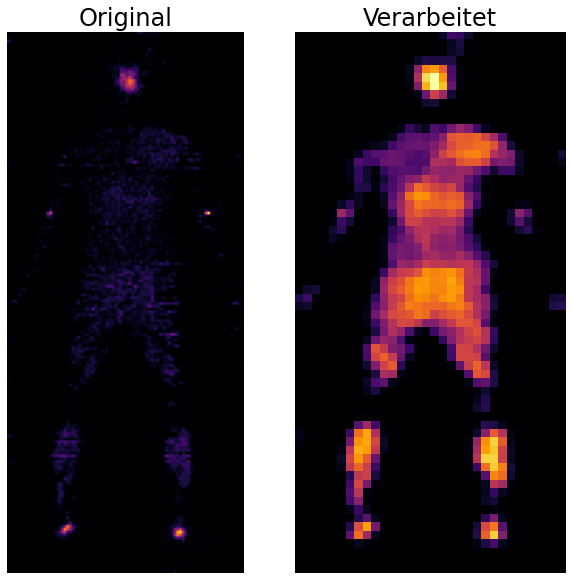

In [100]:
t = torchvision.transforms.Compose(
    [
        # Resize((32, 64)),
        Standardize(),
        NormalizeMinMax(),
        EqualizeHist(),
        Blur((3, 3)),
        Denoise(),
        Threshold(lambda img: np.median(img[img > 0.0])),
        Close((3, 3), ktype=cv2.MORPH_CROSS, iterations=3),
        # Close((3,3), ktype=cv2.MORPH_CROSS, iterations=3),
        Blur((3, 3)),
        Resize((32, 64)),
        # Threshold(lambda img: np.median(img)),
        # Close((2, 4), ktype=cv2.MORPH_CROSS, iterations=2),
        # Erode((2,2), ktype=cv2.MORPH_CROSS, iterations=2),
        # Close((3,3), ktype=cv2.MORPH_CROSS, iterations=2),
    ]
)

images = [slp[0][0], t(slp[0][0])]

image_row(*images, titles=["Original", "Verarbeitet"], cmap="inferno", gridspec_kw={'width_ratios': [0.875, 1]})

# cax = plt.axes([1.0, 0.126, 0.05, 0.754])
# plt.colorbar(
#     cm.ScalarMappable(
#         norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap="inferno"
#     ),
#     cax=cax,
#     orientation="vertical",
#     pad=0.2,
# )

<AxesSubplot:>

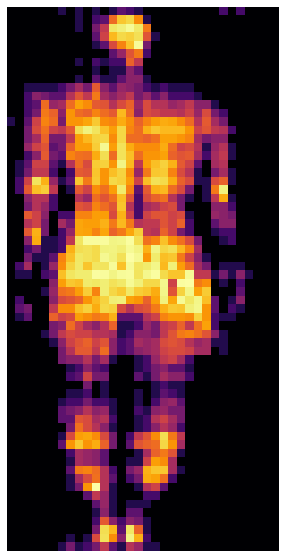

In [82]:
t = torchvision.transforms.Compose(
    [
        NormalizeMinMax(),
        EqualizeHist(),
    ]
)

plot_image(t(physionet[7][0]), cmap="inferno")

# cax = plt.axes([1.0, 0.126, 0.05, 0.754])
# plt.colorbar(
#     cm.ScalarMappable(
#         norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap="inferno"
#     ),
#     cax=cax,
#     # use_gridspec=True,
#     orientation="vertical",
#     pad=0.2,
# )

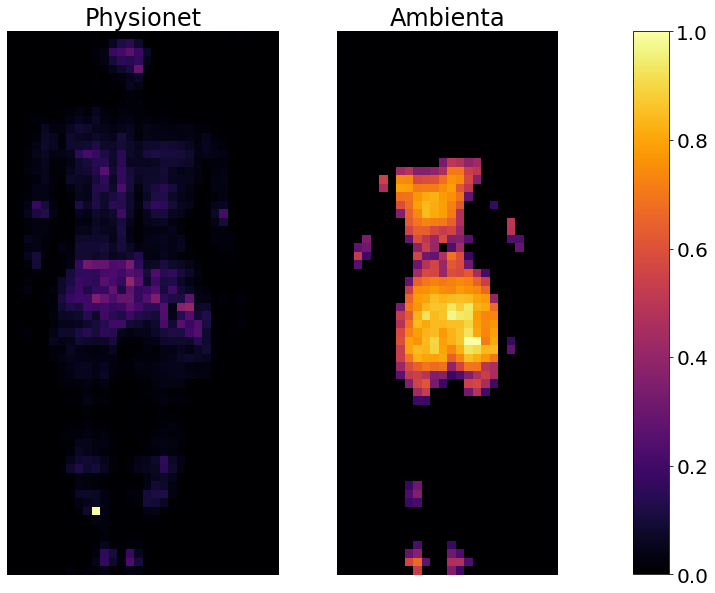

In [22]:
images = [physionet[7][0], ambienta[70][0]]
image_row(*images, titles=["Physionet", "Ambienta"], cmap="inferno", gridspec_kw={'width_ratios': [physionet[7][0].shape[1] / ambienta[70][0].shape[1], 1]})

cax = plt.axes([1.0, 0.126, 0.05, 0.754])
plt.colorbar(
    cm.ScalarMappable(
        norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap="inferno"
    ),
    cax=cax,
    # use_gridspec=True,
    orientation="vertical",
    pad=0.2,
)

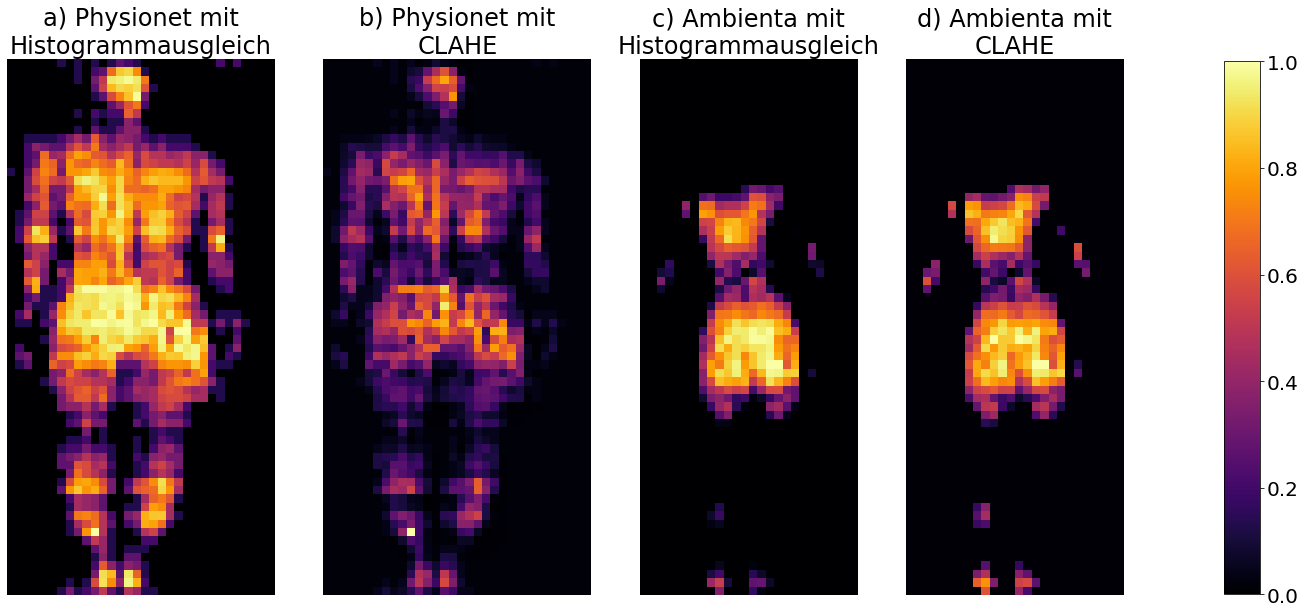

In [54]:
t = torchvision.transforms.Compose(
    [
        NormalizeMinMax(),
        EqualizeHist(),
    ]
)

t2 = torchvision.transforms.Compose(
    [
        NormalizeMinMax(),
        CLAHE(),
    ]
)

images = [t(physionet[7][0]), t2(physionet[7][0]), t(ambienta[70][0]), t2(ambienta[70][0])]

image_row(*images, titles=["a) Physionet mit\nHistogrammausgleich", "b) Physionet mit\nCLAHE", "c) Ambienta mit\nHistogrammausgleich", "d) Ambienta mit\nCLAHE"], figsize=(20, 50), cmap="inferno", gridspec_kw={'width_ratios': [physionet[7][0].shape[1] / ambienta[70][0].shape[1]]*2 + [1, 1]})
# cax = plt.axes([1.0, 0.126, 0.05, 0.754])
cax = plt.axes([0.97, 0.4282, 0.025, 0.148])
plt.colorbar(
    cm.ScalarMappable(
        norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap="inferno"
    ),
    cax=cax,
    # use_gridspec=True,
    orientation="vertical",
    pad=0.2,
)

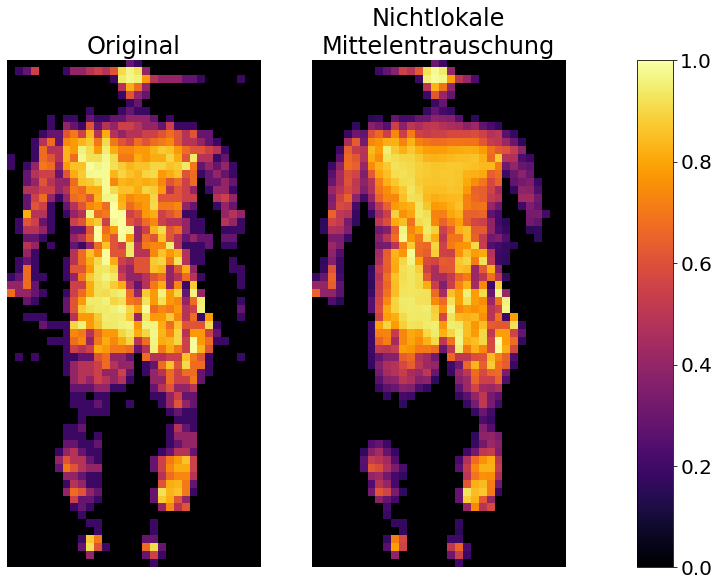

In [109]:
t = torchvision.transforms.Compose(
    [
        Standardize(),
        NormalizeMinMax(),
        EqualizeHist(),
    ]
)

t2 = torchvision.transforms.Compose(
    [
        Resize((32, 64)),
        Standardize(),
        NormalizeMinMax(),
        EqualizeHist(),
        # Resize((64, 128)),
        # Denoise(),
        # Threshold(lambda img: np.mean(img)),
    ]
)
img = t2(physionet[10488][0])
img = np.uint8(img * 255)
img = cv2.fastNlMeansDenoising(img, None, 25, 7, 21)
img = cv2.normalize(img, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
img =  Threshold(lambda img: 0.15)(img)
images = [t(physionet[10488][0]), img]

image_row(*images, titles=["Original", "Nichtlokale\nMittelentrauschung"], cmap="inferno")
cax = plt.axes([1.0, 0.15, 0.05, 0.704])
# cax = plt.axes([0.97, 0.4282, 0.025, 0.148])
plt.colorbar(
    cm.ScalarMappable(
        norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap="inferno"
    ),
    cax=cax,
    # use_gridspec=True,
    orientation="vertical",
    pad=0.2,
)

# Morphologische Operationen

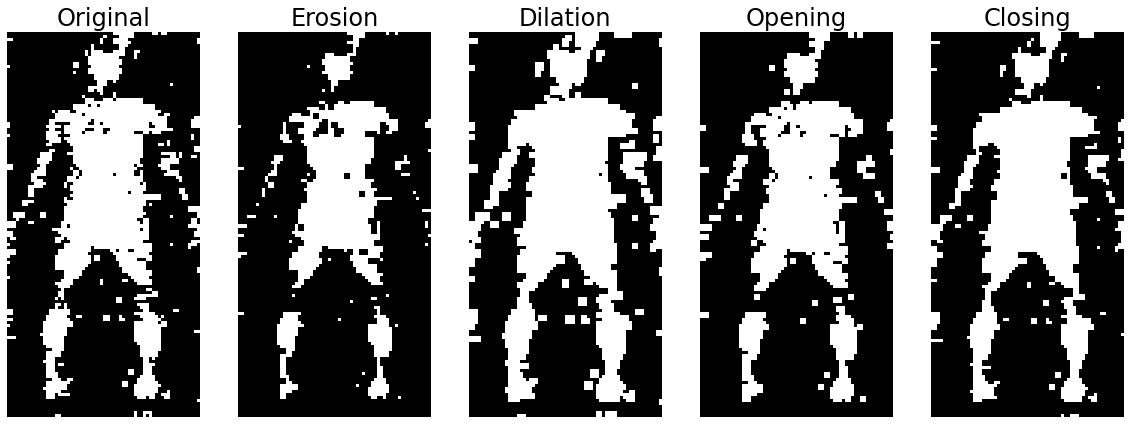

In [3]:
t = torchvision.transforms.Compose(
    [
        Standardize(),
        NormalizeMinMax(),
        EqualizeHist(),
        Resize((64, 128)),
        Threshold(lambda img: 0.0, type=cv2.THRESH_BINARY),
    ]
)
tt = torchvision.transforms.Compose(
    [
        Standardize(),
        NormalizeMinMax(),
        EqualizeHist(),
        Resize((64, 128)),
        Threshold(lambda img: 0.0, type=cv2.THRESH_BINARY),
        Erode((2, 2)),
    ]
)
ttt = torchvision.transforms.Compose(
    [
        Standardize(),
        NormalizeMinMax(),
        EqualizeHist(),
        Resize((64, 128)),
        Threshold(lambda img: 0.0, type=cv2.THRESH_BINARY),
        Dilate((2, 2)),
    ]
)
tttt = torchvision.transforms.Compose(
    [
        Standardize(),
        NormalizeMinMax(),
        EqualizeHist(),
        Resize((64, 128)),
        Threshold(lambda img: 0.0, type=cv2.THRESH_BINARY),
        Open((2, 2)),
    ]
)
ttttt = torchvision.transforms.Compose(
    [
        Standardize(),
        NormalizeMinMax(),
        EqualizeHist(),
        Resize((64, 128)),
        Threshold(lambda img: 0.0, type=cv2.THRESH_BINARY),
        Close((2, 2)),
    ]
)
image = slp[0][0]

images = [t(image), tt(image), ttt(image), tttt(image), ttttt(image)]

image_row(*images, titles=["Original", "Erosion", "Dilation", "Opening", "Closing"], figsize=(20, 10))

# Hoch- und Tiefpassfilter

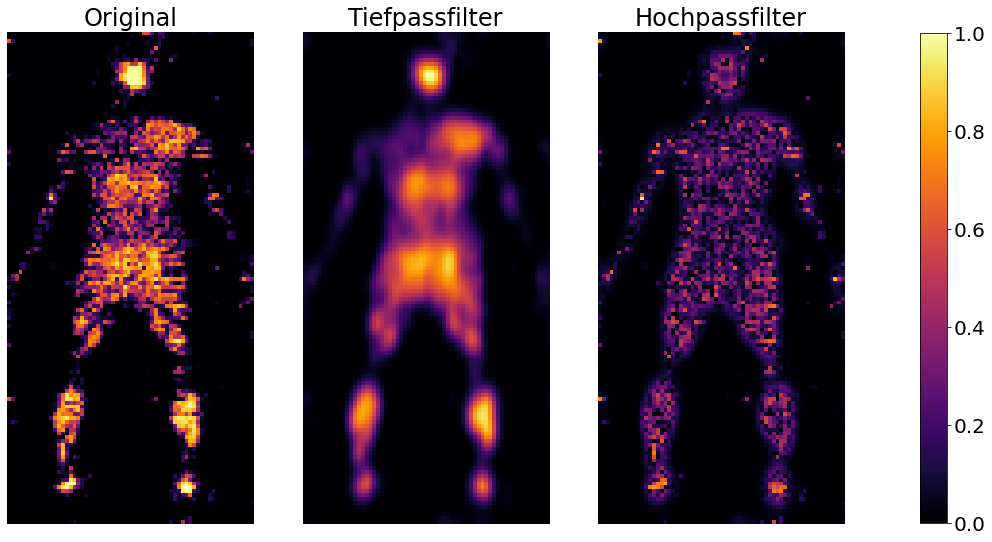

In [120]:
t = torchvision.transforms.Compose(
    [
        Standardize(),
        NormalizeMinMax(),
        EqualizeHist(),
        Resize((64, 128)),
    ]
)
tt = torchvision.transforms.Compose(
    [
        Standardize(),
        NormalizeMinMax(),
        EqualizeHist(),
        Resize((64, 128)),
        LowPass(rad=60),
    ]
)
ttt = torchvision.transforms.Compose(
    [
        Standardize(),
        NormalizeMinMax(),
        EqualizeHist(),
        Resize((64, 128)),
        HighPass(rad=60),
    ]
)
image = slp[0][0]
images = [t(image), tt(image), ttt(image)]

image_row(*images, titles=["Original", "Tiefpassfilter", "Hochpassfilter", "Opening", "Closing"], figsize=(15, 10), cmap="inferno")
cax = plt.axes([0.97, 0.162, 0.025, 0.681])
plt.colorbar(
    cm.ScalarMappable(
        norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap="inferno"
    ),
    cax=cax,
    # use_gridspec=True,
    orientation="vertical",
    pad=0.2,
)

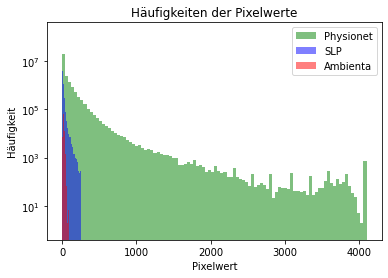

In [42]:
kwargs = dict(alpha=0.5, bins=100)
# plt.rcParams.update({'figure.figsize':(40,15)})

plt.hist(physionet.x.reshape((-1)), **kwargs, color='g', label='Physionet')
plt.hist(slp.x.reshape((-1)), **kwargs, color='b', label='SLP')
plt.hist(ambienta.x.reshape((-1)), **kwargs, color='r', label='Ambienta')

plt.gca().set(title='Häufigkeiten der Pixelwerte', ylabel='Häufigkeit', xlabel="Pixelwert")
plt.yscale("log")
plt.legend();

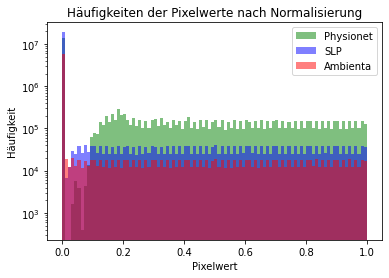

In [41]:
n = torchvision.transforms.Compose(
    [
        Resize((32, 64)),
        Standardize(),
        NormalizeMinMax(),
        EqualizeHist(),
    ]
)

kwargs = dict(alpha=0.5, bins=100)
# plt.rcParams.update({'figure.figsize':(40,15)})

p = np.array([n(i) for i in physionet.x])
s = np.array([n(i) for i in slp.x])
a = np.array([n(i) for i in ambienta.x])
plt.hist(p.reshape((-1)), **kwargs, color='g', label='Physionet')
plt.hist(s.reshape((-1)), **kwargs, color='b', label='SLP')
plt.hist(a.reshape((-1)), **kwargs, color='r', label='Ambienta')

plt.gca().set(title='Häufigkeiten der Pixelwerte nach Normalisierung', ylabel='Häufigkeit', xlabel="Pixelwert")
plt.yscale("log")
plt.legend();

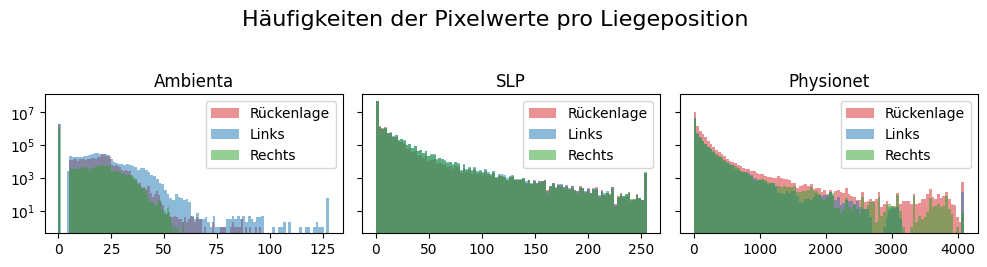

In [40]:
# Plot
fig, axes = plt.subplots(1, 3, figsize=(10,2.5), dpi=100, sharex=False, sharey=True)
colors = ['tab:red', 'tab:blue', 'tab:green']
titles = ["Ambienta", "SLP", "Physionet"]
ds = [ambienta, slp, physionet]

for i, ax in enumerate(axes.flatten()):
    d = ds[i]
    supine = d.x[d.y == 0]
    left = d.x[d.y == 1]
    right = d.x[d.y == 2]
    ax.hist(supine.reshape((-1)), alpha=0.5, bins=100, label="Rückenlage", color=colors[0])
    ax.hist(left.reshape((-1)), alpha=0.5, bins=100, label="Links", color=colors[1])
    ax.hist(right.reshape((-1)), alpha=0.5, bins=100, label="Rechts", color=colors[2])
    ax.set_title(titles[i])
    ax.legend()

plt.suptitle('Häufigkeiten der Pixelwerte pro Liegeposition', y=1.05, size=16)
plt.yscale("log")
# ax.set_xlim(50, 70); ax.set_ylim(0, 1);
plt.tight_layout();

In [51]:
# Plot
colors = ['tab:red', 'tab:blue', 'tab:green']
titles = ["Ambienta", "SLP", "Physionet"]
ds = [ambienta, slp, physionet]

d = ds[2]
supine = d.x[d.y == 0]
left = d.x[d.y == 1]
right = d.x[d.y == 2]
print(np.mean(supine), np.mean(left), np.mean(right))

41.451168 39.46383 40.790123


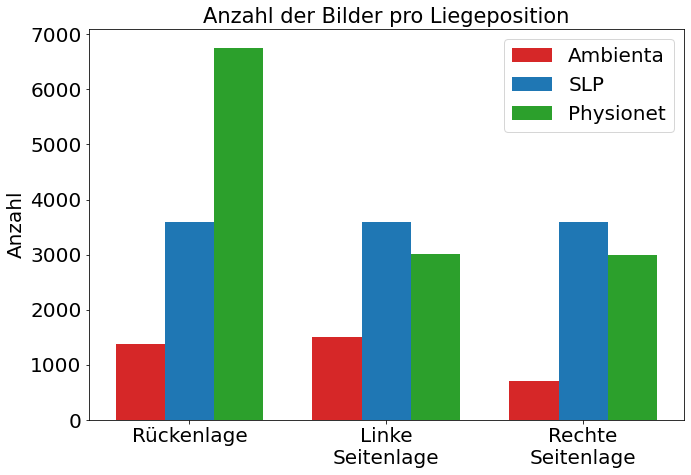

In [108]:
# Plot
colors = ['tab:red', 'tab:blue', 'tab:green']
titles = ["Ambienta", "SLP", "Physionet"]
ds = [ambienta, slp, physionet]
width = 0.35



labels = ['Rückenlage', 'Linke\nSeitenlage', 'Rechte\nSeitenlage']
a_labels = [len(ambienta.x[ambienta.y == 0]), len(ambienta.x[ambienta.y == 1]), len(ambienta.x[ambienta.y == 2])]
s_labels = [len(slp.x[slp.y == 0]), len(slp.x[slp.y == 1]), len(slp.x[slp.y == 2])]
p_labels = [len(physionet.x[physionet.y == 0]), len(physionet.x[physionet.y == 1]), len(physionet.x[physionet.y == 2])]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(10,7))
rects1 = ax.bar(x - width, a_labels, width, label='Ambienta', color=colors[0])
rects2 = ax.bar(x, s_labels, width, label='SLP', color=colors[1])
rects3 = ax.bar(x + width, p_labels, width, label='Physionet', color=colors[2])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Anzahl')
ax.set_title('Anzahl der Bilder pro Liegeposition', fontsize=21)
ax.set_xticks(x, labels)
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()


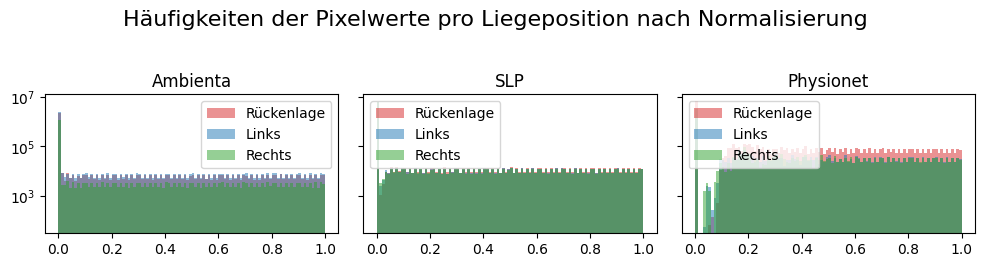

In [39]:
# Plot
fig, axes = plt.subplots(1, 3, figsize=(10,2.5), dpi=100, sharex=False, sharey=True)
colors = ['tab:red', 'tab:blue', 'tab:green']
titles = ["Ambienta", "SLP", "Physionet"]
n = torchvision.transforms.Compose(
    [
        Resize((32, 64)),
        Standardize(),
        NormalizeMinMax(),
        EqualizeHist(),
    ]
)

kwargs = dict(alpha=0.5, bins=100)
# plt.rcParams.update({'figure.figsize':(40,15)})

ds = [ambienta, slp, physionet]

for i, ax in enumerate(axes.flatten()):
    d = ds[i]
    dx = np.array([n(i) for i in d.x])
    supine = dx[d.y == 0]
    left = dx[d.y == 1]
    right = dx[d.y == 2]
    ax.hist(supine.reshape((-1)), alpha=0.5, bins=100, label="Rückenlage", color=colors[0])
    ax.hist(left.reshape((-1)), alpha=0.5, bins=100, label="Links", color=colors[1])
    ax.hist(right.reshape((-1)), alpha=0.5, bins=100, label="Rechts", color=colors[2])
    ax.set_title(titles[i])
    ax.legend()

plt.suptitle('Häufigkeiten der Pixelwerte pro Liegeposition nach Normalisierung', y=1.05, size=16)
plt.yscale("log")
# ax.set_xlim(50, 70); ax.set_ylim(0, 1);
plt.tight_layout();

[0.8637299300123508, 0.9800718719372754, 0.8396674584323041]
0.8944897534606434


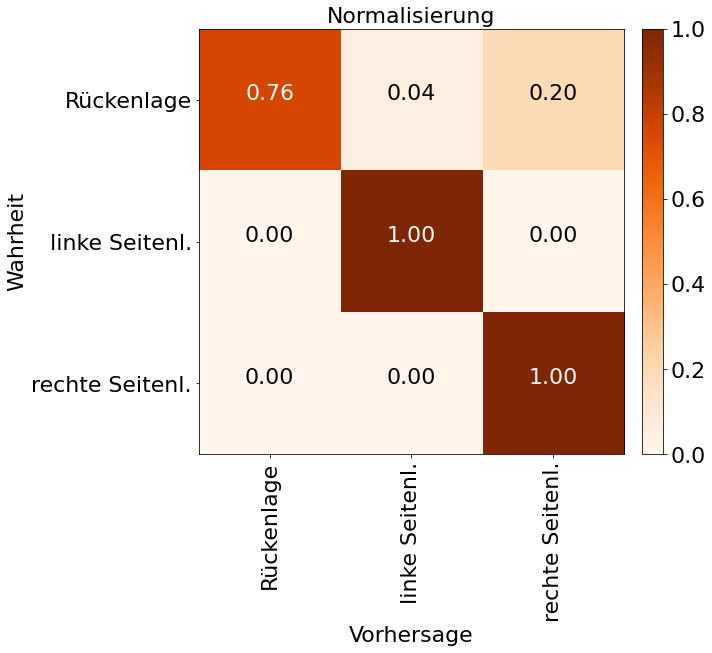

In [3]:
path = Path("runs").joinpath("2022-05-30_08-42-10_Baseline").joinpath("confmat.npy")
conf_mat = np.load(str(path))
print(f1_scores_from_conf_mat(conf_mat))
print(sum(f1_scores_from_conf_mat(conf_mat))/3)
plot_confusion_matrix(conf_mat, title="Normalisierung", normalize=True);

In [79]:
dirs = os.listdir(Path("runs"))
matrices = []
titles = ["Referenzexperiment", "Schwellwertoperation", "Sobel", "Hochpassfilter", "Rauschentfernung", "Dynamisches Schließen", "Zufällige Rotation 30", "Keine Vorverarbeitung", "CLAHE", "Mehrkanal", "Zufällige Rotation 15", "Zufällige Rotation 50"]
f1scores = {}
ref = [0.8944897534606434, 0.8637299300123508, 0.9800718719372754, 0.8396674584323041]
for i, run in enumerate(dirs):
    path = Path("runs").joinpath(run).joinpath("confmat.npy")
    conf_mat = np.load(str(path))
    with open(f"runs/{run}/name.txt", "r") as f:
        name = f.read()
    scores = [sum(f1_scores_from_conf_mat(conf_mat))/3] + f1_scores_from_conf_mat(conf_mat)
    diff = [s - r for s, r in zip(scores, ref)]
    f1scores[titles[i]] = [format(n, '+.3f').replace(".", ",") for n in diff]
for key in f1scores.keys():
    print(f"{key} & {' & '.join(f1scores[key])} \\\\ \\hline")

Referenzexperiment & +0,000 & +0,000 & +0,000 & +0,000 \\ \hline
Schwellwertoperation & +0,002 & +0,005 & +0,009 & -0,009 \\ \hline
Sobel & +0,001 & +0,005 & +0,016 & -0,019 \\ \hline
Hochpassfilter & -0,001 & +0,001 & +0,008 & -0,011 \\ \hline
Rauschentfernung & -0,000 & +0,001 & +0,007 & -0,009 \\ \hline
Dynamisches Schließen & -0,000 & +0,001 & +0,007 & -0,009 \\ \hline
Zufällige Rotation 30 & +0,011 & +0,021 & -0,019 & +0,033 \\ \hline
Keine Vorverarbeitung & -0,478 & -0,270 & -0,654 & -0,510 \\ \hline
CLAHE & +0,006 & +0,014 & +0,019 & -0,015 \\ \hline
Mehrkanal & -0,014 & -0,019 & -0,025 & +0,002 \\ \hline
Zufällige Rotation 15 & -0,004 & -0,010 & -0,025 & +0,023 \\ \hline
Zufällige Rotation 50 & -0,119 & -0,140 & -0,187 & -0,031 \\ \hline


{'Normalisierung': [0.8944897534606434, 0.8637299300123508, 0.9800718719372754, 0.8396674584323041], 'Schwellwertoperation': [0.8960750389910445, 0.8682806729585557, 0.9894459102902375, 0.8304985337243402], 'Sobel': [0.8950553914769758, 0.8682806729585557, 0.9960159362549801, 0.8208695652173913], 'Hochpassfilter': [0.8937736873337331, 0.8646647470176881, 0.9878169245966415, 0.8288393903868698], 'Rauschentfernung': [0.8942828656292677, 0.8650205761316873, 0.9868421052631579, 0.8309859154929577], 'Dynamisches Schließen': [0.8942536644195682, 0.8651315789473684, 0.9868421052631579, 0.8307873090481787], 'Zufällige Rotation 30': [0.9059099629762511, 0.8842606824469721, 0.9608626198083068, 0.8726065866734748], 'Keine Vorverarbeitung': [0.416320292862862, 0.5938310236924452, 0.32590983161325365, 0.3292200232828871], 'CLAHE': [0.9003073676044062, 0.8779304769603881, 0.9986019572598361, 0.8243896685929945], 'Mehrkanal': [0.8804777250324132, 0.8446472115157713, 0.9548204921339251, 0.841965471447

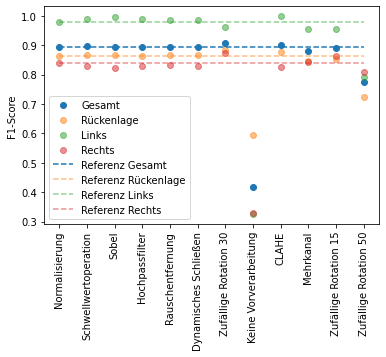

In [5]:
dirs = os.listdir(Path("runs"))
matrices = []
titles = ["Normalisierung", "Schwellwertoperation", "Sobel", "Hochpassfilter", "Rauschentfernung", "Dynamisches Schließen", "Zufällige Rotation 30", "Keine Vorverarbeitung", "CLAHE", "Mehrkanal", "Zufällige Rotation 15", "Zufällige Rotation 50"]
f1scores = {}
for i, run in enumerate(dirs):
    path = Path("runs").joinpath(run).joinpath("confmat.npy")
    conf_mat = np.load(str(path))
    with open(f"runs/{run}/name.txt", "r") as f:
        name = f.read()
    f1scores[titles[i]] = [sum(f1_scores_from_conf_mat(conf_mat))/3] + list( f1_scores_from_conf_mat(conf_mat))
print(f1scores)
i = []
totals = []
supine = []
left = []
right = []
for key in f1scores.keys():
    i.append(key)
    totals.append(f1scores[key][0])
    supine.append(f1scores[key][1])
    left.append(f1scores[key][2])
    right.append(f1scores[key][3])
    
plt.scatter(i, totals, label="Gesamt")
plt.scatter(i, supine, label="Rückenlage", alpha=0.5)
plt.scatter(i, left, label="Links", alpha=0.5)
plt.scatter(i, right, label="Rechts", alpha=0.5)

plt.plot(i, [0.8944897534606434]*len(i), label='Referenz Gesamt', linestyle='--')
plt.plot(i, [0.8637299300123508]*len(i), label='Referenz Rückenlage', linestyle='--', alpha=0.5)
plt.plot(i, [0.9800718719372754]*len(i), label='Referenz Links', linestyle='--', alpha=0.5)
plt.plot(i, [0.8396674584323041]*len(i), label='Referenz Rechts', linestyle='--', alpha=0.5)
plt.xticks(rotation=90)
plt.ylabel("F1-Score")
plt.legend();